# PLN I

## Desafio 4

Se utilizará de base para realizar el desafío la notebook planteada en clase.

Importamos las bilbiotecas que se utilizarán en todo el desafío

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Embedding
from keras.models import Model
from keras.utils import to_categorical
import pickle
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Generación del dataset

Obtenemos el dataset a utilizar, tomando una porción del dataset original (por limitaciones de hardware) y realizando las transformaciones pertinentes.

In [2]:
text_file = "./spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 8000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones 
    # en ambos idiomas
    if '\t' not in line: 
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 8000


## 2. Preprocesamiento

Definimos un tamaño máximo para el vocabulario

In [3]:
MAX_VOCAB_SIZE = 6000

Necesitaremos realizar un Tokenizador para cada idioma, por la tanto realizamos:

**Tokenizador para Inglés**

In [4]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 4447
Sentencia de entrada más larga: 32


**Tokenizador para Español**

Cómo el español cuenta con los símbolos "¿" y "¡" que no están presentes en los filters por defecto, lo explicitamos de manera directa

In [5]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) #max(word2idx_outputs.values()) + 1

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 6781
Sentencia de salida más larga: 36


Luego, definimos el tamaño máximo de entrada y de salida. Utilizamos valores inferiores a los valores máximos de las entrada y salida por limitaciones de hardware.

In [6]:
max_input_len = 16
max_out_len = 18

Generamos los paddings de los vectores de entrada y de salida, diferenciando la posición de los ceros a la izquierda y derecha respectivamente

In [7]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')

Se mantiene categorical_crossentropy como función de pérdida, lo que requiere codificar las salidas del decoder en formato one-hot mediante to_categorical.

In [8]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

## 3. Preparación de embeddings

Para las palabras en inglés, se utilizarán embeddings preentrenados GloVe 6B 50d, entrenados sobre un corpus de Wikipedia y Gigaword, con vectores de 50 dimensiones.

In [10]:
if os.access('glove.6B.50d.pkl', os.F_OK):
    print("Los embeddings 'glove.6B.50d.pkl' ya están descargados. Cargando...")
    with open('glove.6B.50d.pkl', 'rb') as f:
        glove_embeddings = pickle.load(f)
    print(f"Embeddings cargados. Cantidad de palabras: {len(glove_embeddings)}")
else:
    print("El archivo 'glove.6B.50d.pkl' no se encontró en la carpeta. Por favor, colócalo en el mismo directorio.")

Los embeddings 'glove.6B.50d.pkl' ya están descargados. Cargando...
Embeddings cargados. Cantidad de palabras: 399998


A continuación generamos una clase que carga embeddings de palabras desde el archivo pickle previamente generado y construye los diccionarios para mapear palabras e índices. 

El método *__init__* fue modificado para simplificar el flujo de inicialización y evitar generar el pickle en tiempo de ejecución. Esto permite cargar los embeddings de forma más rápida y segura, asumiendo que el pickle fue creado en un paso previo.

El método *get_words_embeddings* fue modificado para acceder a los embeddings por un acceso directo mediante clave, devolviendo un vector de ceros si la palabra no existe en el diccionario.

In [11]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            raise FileNotFoundError(f"El archivo {self.PKL_PATH} no se encontró.")
        
        embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings

        words = list(self.embeddings.keys())
        self.word2idx = {word: idx for idx, word in enumerate(words)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}


    def get_words_embeddings(self, words):
        return np.array([
            self.embeddings.get(word, np.zeros(self.N_FEATURES, dtype=np.float32))
            for word in words
        ])

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = ''
    PKL_PATH = 'glove.6B.50d.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

Instanciamos GloveEmbeddings

In [12]:
model_embeddings = GloveEmbeddings()

Luego, construimos la matriz de embeddings para el vocabulario de entrada

In [25]:
print('preparing embedding matrix...')
embed_dim = 50
words_not_found = []

# word_index provieen del tokenizer

nb_words = max(word2idx_inputs.values()) + 1
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1
asdad 4447


### 4. Entrenamiento del modelo

Definimos el encoder-decoder con LSTM para traducción.

In [14]:
n_units = 128

encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

c:\Users\gaston.e_parsimotion\anaconda3\envs\EIA_PLN\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16, 50)    │    222,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 18, 128)   │    768,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     91,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 18, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 18, 6000)  │    774,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,987,632 (7.58 MB)

 Trainable params: 1,765,232 (6.73 MB)

 Non-trainable params: 222,400 (868.75 KB)

A continuación difino el modelo de decoder que se utilizará durante la inferencia para generar secuencias palabra por palabra. Este modelo recibe como entrada la palabra previa y los estados ocultos, y devuelve la predicción de la siguiente palabra junto con los nuevos estados.

In [15]:
encoder_model= Model(encoder_inputs, encoder_states)

In [16]:
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

Luego, entrenamos el modelo

In [17]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15, 
    validation_split=0.2)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.5879 - loss: 4.5540 - val_accuracy: 0.6952 - val_loss: 2.0767
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.6672 - loss: 2.3155 - val_accuracy: 0.7018 - val_loss: 1.9958
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.6769 - loss: 2.2006 - val_accuracy: 0.7056 - val_loss: 1.9556
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.6807 - loss: 2.1334 - val_accuracy: 0.7105 - val_loss: 1.9089
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - accuracy: 0.6874 - loss: 2.0491 - val_accuracy: 0.7130 - val_loss: 1.8665
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - accuracy: 0.6949 - loss: 1.9627 - val_accuracy: 0.7135 - val_loss: 1.8401
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.7050 - loss: 1.8727 - val_accuracy: 0.7187 - val_loss: 1.8021
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - accuracy: 0.7036 - loss: 1

Observamos la evolución de la métrica de evaluación a lo largo de las épocas

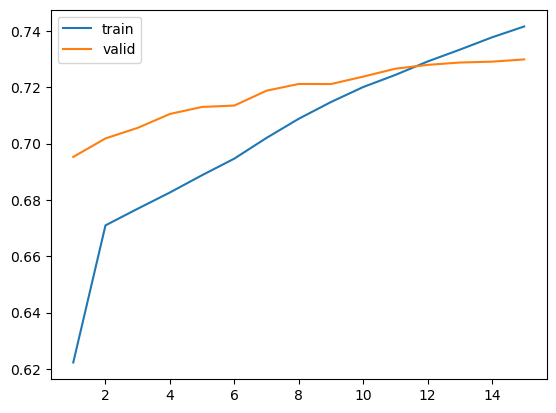

In [18]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

## 5. Uso del modelo y análisis de resultados

Primero, generamos los conversores de índices a palabras

In [19]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

Luego, planteamos la function vista en clase para traducir una secuencia utilizando el modelo encoder-decoder en modo inferencia. La función genera la salida palabra por palabra, comenzando con el token de inicio y realimentando cada predicción como entrada del paso siguiente. El proceso se detiene al alcanzar el token de fin de secuencia o el máximo de longitud permitido, devolviendo la traducción generada.

In [20]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

Para evaluar la calidad del modelo de traducción entrenado, se diseñó un esquema de pruebas escalonado que busca medir su capacidad de generalización en diferentes niveles de complejidad y tipo de frases. Este enfoque permite observar no solo si el modelo logra traducir correctamente frases simples, sino también cómo se comporta frente a expresiones más complejas o especializadas.

A continuación, se describen los distintos niveles planteados:

- Prueba 1 - Traducción de palabras
    - Se evalúa la capacidad del modelo para traducir palabras individuales. Este es el nivel más básico, donde se espera que el modelo pueda mapear correctamente vocabulario simple y frecuente
- Prueba 2 - Frases muy cortas y directas
    - Se prueban frases simples con estructura gramatical mínima (sujeto + verbo + atributo/complemento). Estas oraciones son de baja complejidad sintáctica
- Prueba 3 - Frases cotidianas simples
    - Se presentan oraciones un poco más largas y representativas del lenguaje diario, que incluyen preposiciones o determinantes, pero mantienen una sintaxis directa y sin subordinadas
- Prueba 4 - Frases con conectores
    - Este nivel incluye frases que combinan ideas mediante conectores (if, because, when, although), lo que introduce una mayor complejidad sintáctica
- Prueba 5 - Expresiones idiomáticas y dominio técnico
    - Prueba 5A: Frases cotidianas largas con expresiones compuestas típicas del lenguaje hablado.
    - Prueba 5B: Expresiones idiomáticas, que no deben traducirse de forma literal.
    - Prueba 5C: Frases del ámbito técnico o científico, con términos específicos y menos frecuentes.



In [21]:
test_cases = {
    # Nivel 1: Traducción de palabras
    "Prueba 1 - Traducción de palabras": [
        ("dog", "perro"),
        ("blue", "azul"),
        ("house", "casa"),
        ("thanks", "gracias"),
        ("run", "correr")
    ],

    # Nivel 2: Frases muy cortas y directas
    "Prueba 2 - Frases muy cortas": [
        ("I am happy.", "Estoy feliz."),
        ("She runs fast.", "Ella corre rápido."),
        ("The dog sleeps.", "El perro duerme."),
        ("This is blue.", "Esto es azul."),
        ("He eats apples.", "Él come manzanas.")
    ],

    # Nivel 3: Frases cotidianas simples
    "Prueba 3 - Frases cotidianas simples": [
        ("I want a coffee.", "Quiero un café."),
        ("The cat sleeps on the bed.", "El gato duerme en la cama."),
        ("My friend is at home.", "Mi amigo está en casa."),
        ("We play football.", "Nosotros jugamos al fútbol."),
        ("She reads a book.", "Ella lee un libro.")
    ],

    # Nivel 4: Frases con subordinadas o conectores
    "Prueba 4 - Frases con conectores": [
        ("I will go if it rains.", "Iré si llueve."),
        ("She was happy because she won.", "Ella estaba feliz porque ganó."),
        ("When I see him, I smile.", "Cuando lo veo, sonrío."),
        ("If you want, we can go.", "Si quieres, podemos ir."),
        ("Although it was late, he stayed.", "Aunque era tarde, se quedó.")
    ],

    # Nivel 5: Expresiones idiomáticas / técnicas (ya hecho)
    "Prueba 5A - Frases cotidianas": [
        ("Good morning, how did you wake up?", "Buenos días, ¿cómo amaneciste?"),
        ("The cat sleeps on the pillow.", "El gato duerme sobre la almohada."),
        ("It’s going to rain this afternoon.", "Hoy va a llover por la tarde."),
        ("I need to book a table for two.", "Necesito reservar una mesa para dos."),
        ("See you on Friday at six.", "Nos vemos el viernes a las seis.")
    ],
    "Prueba 5B - Expresiones idiomáticas": [
        ("A bird in the hand is worth two in the bush.", "Más vale pájaro en mano que cien volando."),
        ("I’m between a rock and a hard place.", "Estoy entre la espada y la pared."),
        ("I completely lost track of time.", "Se me fue el santo al cielo."),
        ("Don’t do anything without a reason.", "No des puntada sin hilo."),
        ("This is a piece of cake.", "Esto es pan comido.")
    ],
    "Prueba 5C - Robustez técnica": [
        ("The CPU reached 3.6 GHz during the stress test.", "La CPU alcanzó 3,6 GHz durante la prueba de estrés."),
        ("Apply a Sobel filter to detect edges.", "Aplique un filtro de Sobel para detectar bordes."),
        ("The patient has chronic arterial hypertension.", "El paciente presenta hipertensión arterial crónica."),
        ("The API requires OAuth 2.0 authentication with the PKCE flow.", "La API requiere autenticación OAuth 2.0 con flujo PKCE."),
        ("Add two teaspoons of baking powder to the mixture.", "Añada dos cucharaditas de polvo de hornear a la mezcla.")
    ]
}

# Función auxiliar para preparar la secuencia de entrada
def sentence_to_input_seq(sentence, tokenizer, max_input_len):
    seq = tokenizer.texts_to_sequences([sentence])
    seq_padded = pad_sequences(seq, maxlen=max_input_len, padding='post')
    return seq_padded

# Evaluar el modelo sobre los conjuntos
for test_name, cases in test_cases.items():
    print(f"\n==== {test_name} ====")
    for source, expected in cases:
        input_seq = sentence_to_input_seq(source, input_tokenizer, max_input_len)
        translation = translate_sentence(input_seq)
        print(f"Entrada: {source}")
        print(f"Esperado: {expected}")
        print(f"Generado: {translation}\n")


==== Prueba 1 - Traducción de palabras ====
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Entrada: dog
Esperado: perro
Generado: ¡órale

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Entrada: blue
Esperado: azul
Generado: ¡órale

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Entrada: house
Esperado: casa
Generado: cu

**Observaciones**

El nivel de complejidad creciente de las pruebas no mostró una degradación progresiva en el rendimiento: el modelo falló desde el nivel más simple.

Esto sugiere que el problema no está relacionado con la complejidad gramatical de las frases, sino con que el modelo no aprendió correctamente el mapeo entre los inputs y outputs.

Incluso las palabras sueltas (nivel 1) no pudieron ser traducidas, lo que es un indicador temprano de que el modelo no alcanzó aprendizaje útil.

A medida que aumentó la complejidad, el modelo no mostró cambios significativos en la calidad de las salidas: las frases siguieron siendo incoherentes o aleatorias.

## Conclusiones

Los resultados obtenidos mostraron que el modelo no logró un aprendizaje efectivo del mapeo entre las oraciones en inglés y sus traducciones al español. Incluso en los niveles más básicos, como la traducción de palabras aisladas o frases muy cortas, las salidas generadas fueron incoherentes o aleatorias. A medida que aumentó la complejidad de las frases evaluadas, el desempeño del modelo no mostró un deterioro progresivo, sino que se mantuvo deficiente en todos los niveles, lo que sugiere que el problema no estuvo vinculado a la complejidad gramatical de las frases evaluadas.

Las causas potenciales de este bajo desempeño podrían estar relacionadas con distintos factores: el tamaño reducido del conjunto de datos utilizado para el entrenamiento (debido a limitaciones de hardware), la alta dimensionalidad del vocabulario en relación a las muestras disponibles, o la configuración del modelo. Además, aunque se usaron embeddings preentrenados para las palabras en inglés, el modelo podría haberse beneficiado de un mayor volumen de datos o arquitecturas más robustas para captar mejor las relaciones entre las secuencias de entrada y salida.